In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from pprint import pprint
import time

import inputools.Trajectory as it
from tools.evolutions import load_best_individual
import src.models as mm
from src.models import logger
import src.visualizations as mv
import src.agents as agents

from tools.utils import clf, tqdm_enumerate, save_image

%load_ext autoreload
%autoreload 2

plt.style.use('classic')
logger()

2024-02-16 23:08:11 | 


This notebook is about the study of active navigation by exploiting a formed place cell layer.

## hard-coded PC layer 
---

#### Trajectory

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 53433.69it/s]


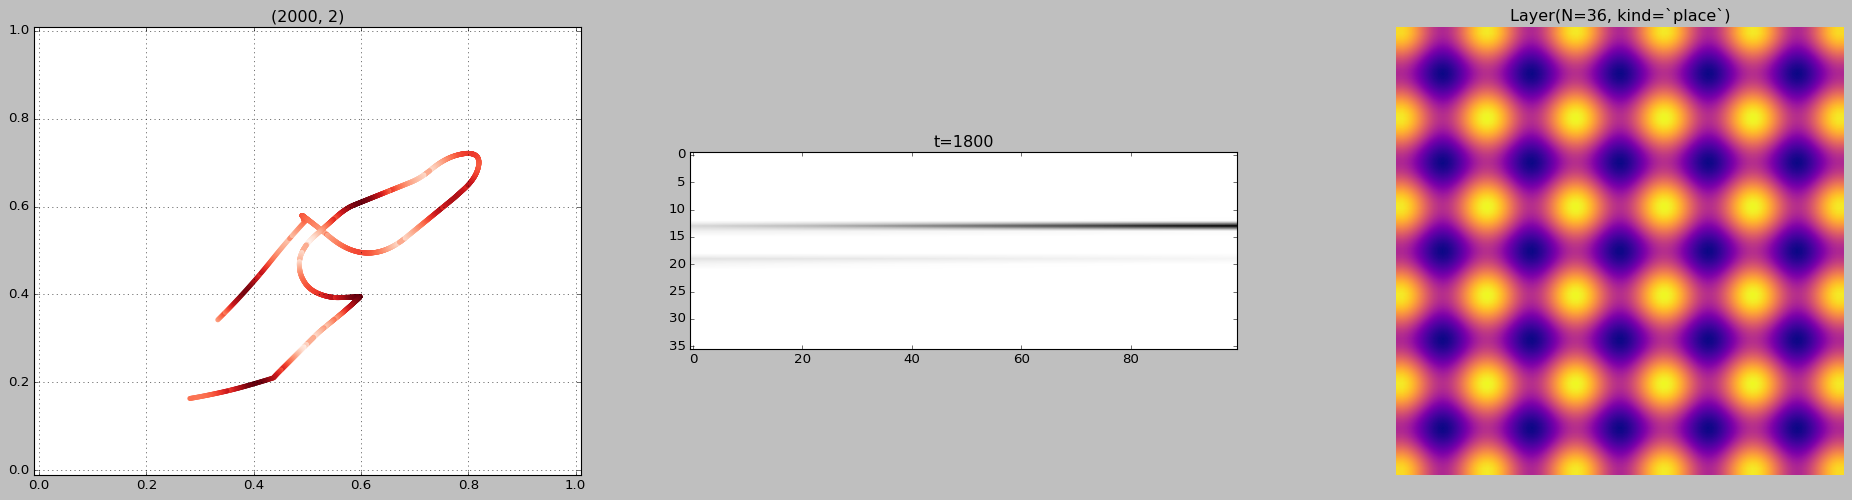

In [192]:
# input
duration = 2
speed = 5e-1
dt = 1e-1
Nj = 6**2
sigma = 0.01

trajectory = it.make_trajectory(duration=duration, dt=dt, speed=[speed, speed], 
                                  prob_turn=0.005, k_average=200, dim=2) * 0.7 + 0.15

#layer = it.HDLayer(N=5**2, sigma=0.01)
layer = it.PlaceLayer(N=Nj, sigma=sigma)

A = layer.parse_trajectory(trajectory=trajectory)

_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 7))
z = np.zeros(len(A))
for i in range(len(A[0])):
    z += np.where(A[:, i] > 0.1, A[:, i], 0)

ax1.scatter(trajectory[:, 0], trajectory[:, 1], c=z, s=20, cmap='Reds',
           edgecolors='black', linewidths=0)
ax1.set_ylim((-0.01, 1.01))
ax1.set_xlim((-0.01, 1.01))
ax1.grid()
ax1.set_title(trajectory.shape)

for t in range(0, len(A)-100, 100):
    ax2.imshow(A[t:t+100, :].T, cmap='Greys')
    ax2.set_title(f"{t=}")
    
layer.plot(size=100, kind='imshow', sigmoid_beta=0.01, sigmoid_alpha=0., ax=ax3)

In [37]:
trajectory[0]

array([0.27475, 0.27475])

In [70]:
np.sqrt(-np.log(agent.pc_post_a*100))

array([[nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan]])

In [80]:
agent = agents.AgentPC(Npc=5**2, Nh=10, start_position=trajectory[0], step_size=0.0001, activation='sigmoid')
agent(goal_position=trajectory[t].copy().reshape(-1, 1))


array([0.50038672, 0.50025293])

In [79]:
agent.layer_pc.centers.T @ agent.pc_post_a / agent.pc_post_a.sum()

array([[0.50016565],
       [0.49972521]])

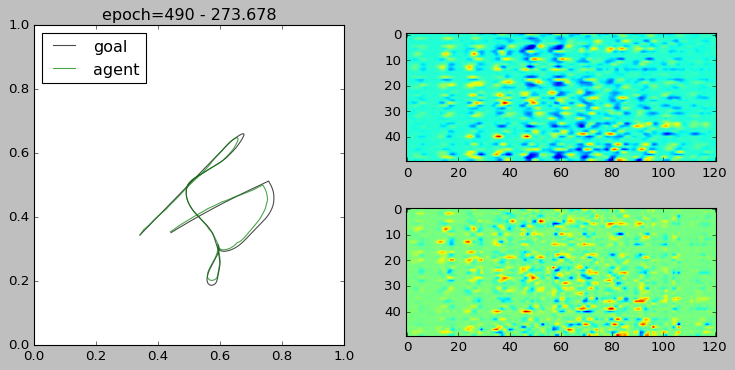

In [234]:
""" initialization """

npc = 11
agent = agents.AgentPC(Npc=npc**2, Nh=50, start_position=trajectory[0].copy(), lr=-0.005, sigma_pc=0.03,
                       activation='relu', activation_out='relu')
logger(agent)

agents.DEBUG = bool(0)
pflag = -1 if agents.DEBUG else 0
epochs = 500
epoch_log = int(max((epochs*0.02, 1)))
looksteps = 2
new_trj = 75
for epoch in range(epochs):

    # new trajectory are periodically created
    if epoch % new_trj == 0:
        trajectory = it.make_trajectory(duration=duration, dt=dt, speed=[speed, speed], 
                                  prob_turn=0.005, k_average=200, dim=2) * 0.7 + 0.15

    # init
    agent.set_position(position=trajectory[0].copy().reshape(-1, 1))
    positions = np.zeros((trajectory.shape[0]-looksteps-1, trajectory.shape[1]))
    positions[0] = trajectory[0].copy()
    loss = 0.

    # train
    for t in range(1, len(trajectory)-looksteps-1):
        positions[t] = agent(goal_position=trajectory[t+looksteps].copy().reshape(-1, 1))
        loss += agent.update(target_position=trajectory[t+looksteps+1].copy().reshape(-1, 1))

        if agents.DEBUG:
            print('##########################')
            clf()
            input()
            plt.subplot(121)
            plt.imshow(agent.goal_pc.reshape(npc, npc))
            plt.grid()
            plt.subplot(122)
            plt.imshow(agent.current_pc.reshape(npc, npc))
            plt.grid()
            plt.show()
            if t == 100: break
            
    #print(positions, end=' ')

    if epoch % epoch_log == pflag:

        clf()
        plt.figure(figsize=(11, 5))
        plt.subplot(121)
        plt.plot(trajectory[:, 0], trajectory[:, 1], '-k', alpha=0.7, label="goal")
        plt.plot(positions[:, 0], positions[:, 1], '-g', alpha=0.7, label="agent")
        plt.xlim((0, 1))
        plt.ylim((0, 1))
        plt.legend(loc="upper left")
        plt.title(f"{epoch=} - {loss:.3f}")

        plt.subplot(222)
        plt.imshow(agent.Wh)

        plt.subplot(224)
        plt.imshow(agent.Wout.T)
        plt.pause(0.0001)

#### Test

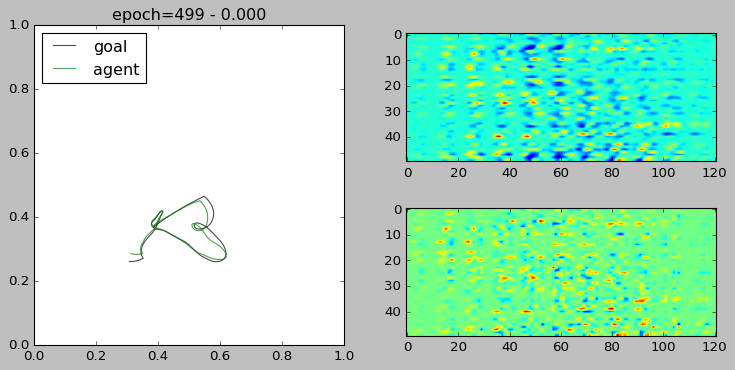

In [243]:
""" settings """
duration = 2
speed = 5e-1
dt = 1e-1

trajectory = it.make_trajectory(duration=duration, dt=dt, speed=[speed, speed], 
                                  prob_turn=0.005, k_average=200, dim=2) * 0.5 + 0.25

""" run """
agent.set_position(position=trajectory[0].copy().reshape(-1, 1))
positions = np.zeros((trajectory.shape[0]-looksteps, trajectory.shape[1]))
positions[0] = trajectory[0].copy()
loss = 0.
for t in range(1, len(trajectory)-looksteps):
    positions[t] = agent(goal_position=trajectory[t+looksteps].copy().reshape(-1, 1))

""" plot """
plt.figure(figsize=(11, 5))
plt.subplot(121)
plt.plot(trajectory[:, 0], trajectory[:, 1], '-k', alpha=0.7, label="goal")
plt.plot(positions[:, 0], positions[:, 1], '-g', alpha=0.7, label="agent")
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.legend(loc="upper left")
plt.title(f"{epoch=} - {loss:.3f}")

plt.subplot(222)
plt.imshow(agent.Wh)

plt.subplot(224)
plt.imshow(agent.Wout.T)
plt.show()